# Setting up the environment

In this section, we import all the necessary libraries that will be used in this notebook. These include libraries for data manipulation, machine learning model creation, evaluation, and visualization.

- **Numpy, Pandas**: For numerical computations and data handling.
- **Matplotlib**: For visualization.
- **Joblib**: To save and load models.
- **Scikit-learn**: To evaluate the model.
- **Mlxtend**: To perform feature selection.
- **XGBoost**: Our machine learning model.

In [36]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from xgboost import XGBRegressor

# Loading the dataset

We load the dataset using pandas. The dataset path is defined using the `dataset_name` and `reduction_method`.

In [37]:
# Load dataset
dataset_name = 'PD'
reduction_method = '_n1_c5_delta'
output_file = os.path.join('Input', f'{dataset_name}{reduction_method}.csv')

In [38]:
df = pd.read_csv(output_file)
df = df.sample(frac=1, random_state=1)

# Feature Engineering

Feature engineering is a critical step. We add cyclical representations of weeks (`week_sin` and `week_cos`) and compute vegetation growth rates using various vegetation indices.

In [39]:
def add_features(df):
    df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
    df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
    df['growth_rate_ndvi'] = df['veg_max_ndvi'] - df['veg_min_ndvi']
    df['growth_rate_evi'] = df['veg_max_evi'] - df['veg_min_evi']
    df['growth_rate_lai'] = df['veg_max_lai'] - df['veg_min_lai']
    df['mean_combined_vegetation_index'] = (df['veg_mean_evi'] + df['veg_mean_ndvi'] + df['veg_mean_lai']) / 3
    return df

In [40]:
# Apply feature engineering
df = add_features(df)

# Defining Predictors and Labels

Here, we define our predictors (`X_yield`) and labels (`y_yield`). We use a dynamic approach to select the predictor columns.

In [41]:
# Define predictors and labels
predictor_columns = df.columns[10:]  # Dynamically determine the selected columns for predictors
predictors_yield = np.append(predictor_columns, 'Crop_num')

In [42]:
X_yield = df[predictors_yield].values
label_col_yield = 'Mean'
y_yield = df[label_col_yield].values.ravel()

# Training the XGBoost Model

We define a function to train the XGBoost model using our predictors and labels. The function also allows parallel processing using multiple CPU cores.

In [43]:
def train_xgboost_model(X, y, ncpus):
    xgb_model = XGBRegressor(objective='reg:squarederror', n_jobs=ncpus, random_state=1)
    xgb_model.fit(X, y)
    return xgb_model

In [44]:
# Train initial XGBoost model to get feature importance
ncpus = 4
xgb_yield = train_xgboost_model(X_yield, y_yield, ncpus)

# Feature Importance and Selection

We compute feature importance from the trained XGBoost model and select the top N features for further processing.

In [45]:
# Get feature importance and select top N features
number_of_features = 30
feature_importances = pd.DataFrame(xgb_yield.feature_importances_, index=predictors_yield, columns=['importance']).sort_values('importance', ascending=False)

In [46]:
# Select top number_of_features features based on importance
top_features = feature_importances.index[:number_of_features]
df1 = df[[label_col_yield] + list(top_features)].copy()
X1 = df1[top_features].values
y = df1[label_col_yield].values.ravel()

# Sequential Feature Selection (SFS)

We apply Sequential Forward Selection (SFS) to further refine the feature set by evaluating the R² score for different feature combinations.

In [47]:
# Perform SFS only on the top N features with early stopping when the increment in R² is less than 0.005
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize variables to track R² improvement
r2_previous = -np.inf  # Set a very low initial value for R²
min_increment = 0.001  # Threshold for stopping
sfs_features = []  # To store selected features

# Perform SFS with early stopping
for k in range(1, number_of_features + 1):
    # SFS step: select the next feature
    sfs = SFS(estimator=xgb_yield, 
              k_features=k, 
              forward=True, 
              floating=False, 
              scoring='r2', 
              cv=cv, 
              n_jobs=ncpus)
    
    sfs = sfs.fit(X1, y)
    
    # Get the R² score after adding the current feature
    r2_current = sfs.k_score_
    
    # Check if the improvement in R² is less than the threshold
    if (r2_current - r2_previous) < min_increment:
        print(f"Early stopping at {k} features. R² improvement ({r2_current - r2_previous:.4f}) is less than {min_increment}.")
        break
    
    # Update the previous R² score and store selected features
    r2_previous = r2_current
    sfs_features = np.array(top_features)[list(sfs.k_feature_idx_)]

# Final selected features after SFS with early stopping
selected_columns = sfs_features
print(f"Selected features: {selected_columns}")


Early stopping at 9 features. R² improvement (0.0010) is less than 0.001.
Selected features: ['Crop_num' 'sar_angle' 'era5_evaporation_from_bare_soil_sum' 'week_sin'
 'era5_totprec' 'era5_swi' 'chirps_cnt_prec' 'RSM_mean']


# Plotting R² Score Improvement with SFS

We plot how the R² score improves as more features are added by SFS.

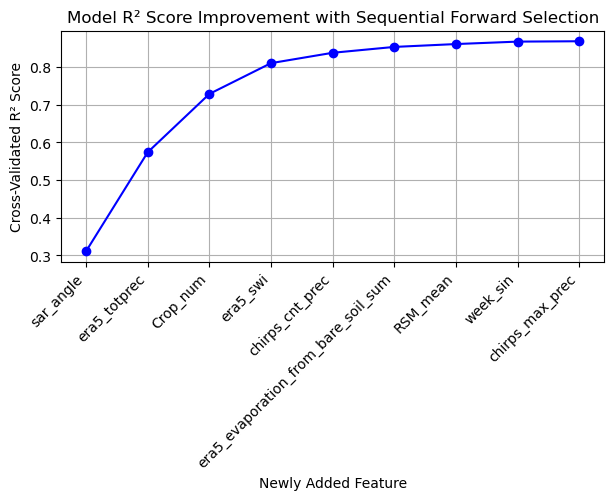

In [48]:
# Plot the R² score improvement (optional)
metric_dict = sfs.get_metric_dict()
new_features, r2_scores = [], []

for i, key in enumerate(metric_dict.keys()):
    r2_scores.append(metric_dict[key]['avg_score'])
    if i == 0:
        new_features.append(top_features[list(metric_dict[key]['feature_idx'])][0])
    else:
        previous_set = set(metric_dict[key - 1]['feature_idx'])
        current_set = set(metric_dict[key]['feature_idx'])
        new_feature = current_set - previous_set
        new_features.append(top_features[list(new_feature)][0])

# Plot the R² score improvement
fig = plt.figure(figsize=(7, 3))
plt.plot(new_features, r2_scores, marker='o', linestyle='-', color='b')
plt.xticks(rotation=45, ha='right')
plt.title('Model R² Score Improvement with Sequential Forward Selection')
plt.xlabel('Newly Added Feature')
plt.ylabel('Cross-Validated R² Score')
plt.grid(True)
plt.show()

# Plotting Feature Importance after Forward Selection

We plot the feature importance of the final model trained with the selected features after the forward selection process.

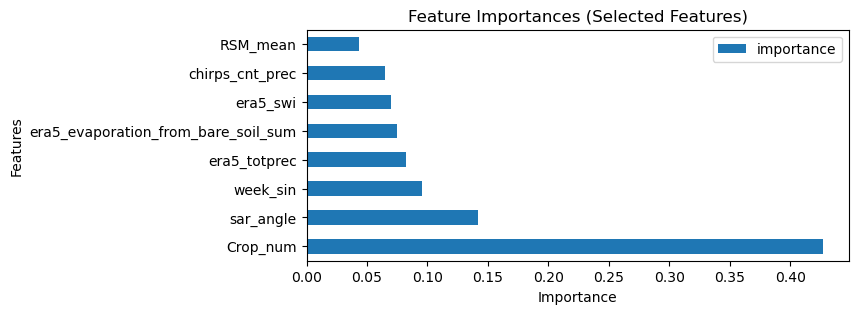

In [49]:
# Assuming you already performed SFS and have 'selected_columns'
# Step 1: Train the final model using selected features after SFS

# Define the predictors using selected features from SFS
X_selected = df[selected_columns].values  # df is your original dataframe

# Train the final XGBoost model using the selected features
xgb_final = XGBRegressor(objective='reg:squarederror', n_jobs=4, random_state=1)
xgb_final.fit(X_selected, df['Mean'].values.ravel())  # Assuming 'Mean' is your target variable

# Step 2: Plot the feature importances of the final trained model
feature_importances_final = pd.DataFrame(xgb_final.feature_importances_, 
                                         index=selected_columns, 
                                         columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 3))
feature_importances_final.plot(kind='barh', ax=ax)
ax.set_title('Feature Importances (Selected Features)')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
plt.show()

# Train-test Split and Evaluation

We split the data into training (75%) and testing (25%) sets, train the model using the training data, and evaluate the model's performance using the test data. The results are displayed in a scatter plot with different colors for training and testing points.

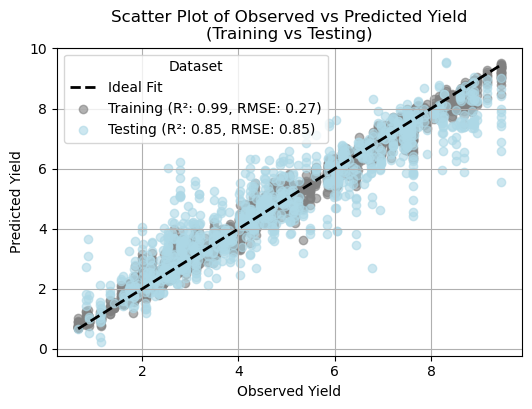

In [50]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df1[selected_columns].values, df1[label_col_yield].values, test_size=0.25, random_state=1)

# Train final model using training data
xgb_final = train_xgboost_model(X_train, y_train, ncpus)

# Predict on both training and test sets
train_pred = xgb_final.predict(X_train)
test_pred = xgb_final.predict(X_test)

# Evaluate model performance
r2_train = r2_score(y_train, train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))

r2_test = r2_score(y_test, test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))

# Scatter plot of observed vs predicted yield for train and test sets
fig = plt.figure(figsize=(6, 4))

# Plot training points
plt.scatter(y_train, train_pred, label=f'Training (R²: {r2_train:.2f}, RMSE: {rmse_train:.2f})', color='gray', alpha=0.6)

# Plot test points
plt.scatter(y_test, test_pred, label=f'Testing (R²: {r2_test:.2f}, RMSE: {rmse_test:.2f})', color='lightblue', alpha=0.6)

# Plot ideal fit line
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 'k--', lw=2, label='Ideal Fit')

plt.xlabel('Observed Yield')
plt.ylabel('Predicted Yield')
plt.title('Scatter Plot of Observed vs Predicted Yield\n(Training vs Testing)')
plt.legend(title="Dataset")
plt.grid(True)
plt.show()


# Saving the Final Model and Results

We save the final model and the selected features to files for future use. The model is saved as a `.joblib` file, and the selected features are saved as a JSON file.

In [51]:
# Save model and selected features
model_basepath = 'Models'
os.makedirs(model_basepath, exist_ok=True)
model_path = os.path.join(model_basepath, f'{dataset_name}{reduction_method}_xb{number_of_features}.joblib')
dump(xgb_final, model_path)

['Models/PD_n1_c5_delta_xb30.joblib']

In [52]:
features_path = os.path.join(model_basepath, f'{dataset_name}{reduction_method}_xb{number_of_features}.json')
with open(features_path, "w", encoding="utf-8") as f:
    json.dump({"features": list(selected_columns)}, f, ensure_ascii=False, indent=4)